In [1]:
# Cek GPU
import torch, platform
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))
print("Python:", platform.python_version())

PyTorch: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4
Python: 3.12.12


In [2]:
!pip install -q timm scikit-learn tqdm gdown

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import os

DATA_ROOT = "/content/drive/MyDrive/animal_class/dataset_balanced"

# cek apakah folder ditemukan
assert os.path.isdir(DATA_ROOT), f"Folder {DATA_ROOT} tidak ditemukan!"
print("Dataset folder ditemukan:", DATA_ROOT)

print("Isi dataset_balanced:")
print(os.listdir(DATA_ROOT))  # harus ada: train, val, test

print("\nIsi TRAIN:")
print(os.listdir(os.path.join(DATA_ROOT, "train")))

print("\nIsi VAL:")
print(os.listdir(os.path.join(DATA_ROOT, "val")))

print("\nIsi TEST:")
print(os.listdir(os.path.join(DATA_ROOT, "test")))


Dataset folder ditemukan: /content/drive/MyDrive/animal_class/dataset_balanced
Isi dataset_balanced:
['test', 'train', 'val']

Isi TRAIN:
['Frog', 'Chameleon', 'Snake', 'Iguana', 'Turtle_Tortoise']

Isi VAL:
['Chameleon', 'Frog', 'Turtle_Tortoise', 'Snake', 'Iguana']

Isi TEST:
['Chameleon', 'Frog', 'Iguana', 'Turtle_Tortoise', 'Snake']


In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMG_SIZE = 224
BATCH_SIZE = 32

from torchvision import transforms

tf_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.02),
    transforms.ToTensor(),
])

tf_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(f"{DATA_ROOT}/train", transform=tf_train)
val_ds   = datasets.ImageFolder(f"{DATA_ROOT}/val",   transform=tf_eval)
test_ds  = datasets.ImageFolder(f"{DATA_ROOT}/test",  transform=tf_eval)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Train:", len(train_ds), " | Val:", len(val_ds), " | Test:", len(test_ds))


Classes: ['Chameleon', 'Frog', 'Iguana', 'Snake', 'Turtle_Tortoise']
Train: 700  | Val: 149  | Test: 150


In [6]:
import os, random, time
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import timm
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

SEED = 50
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Speed tweaks
torch.backends.cudnn.benchmark = True
use_amp = torch.cuda.is_available()


Device: cuda


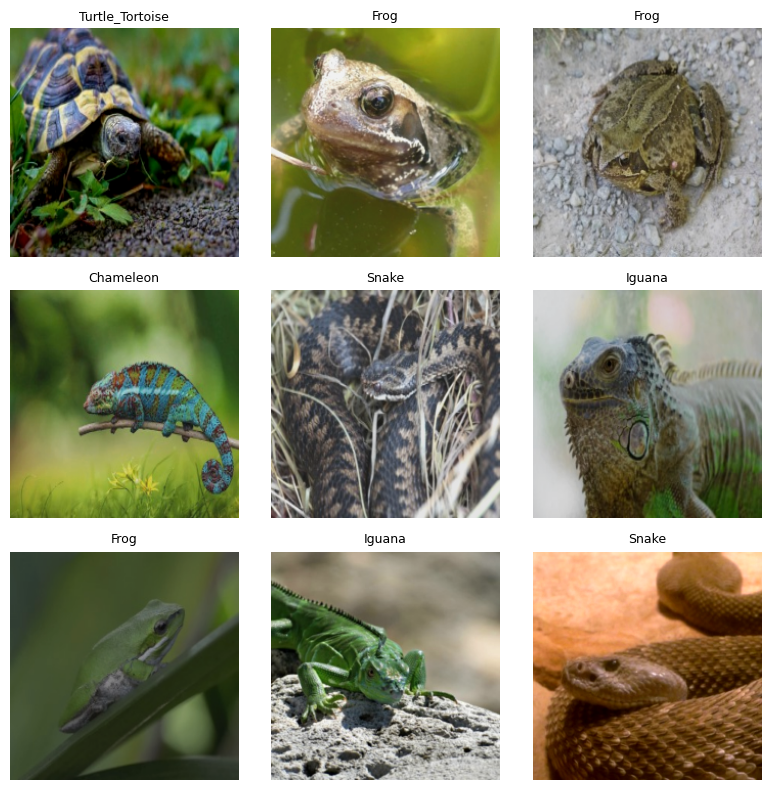

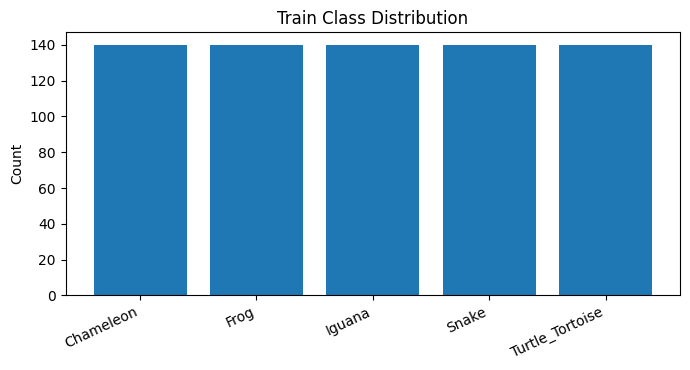

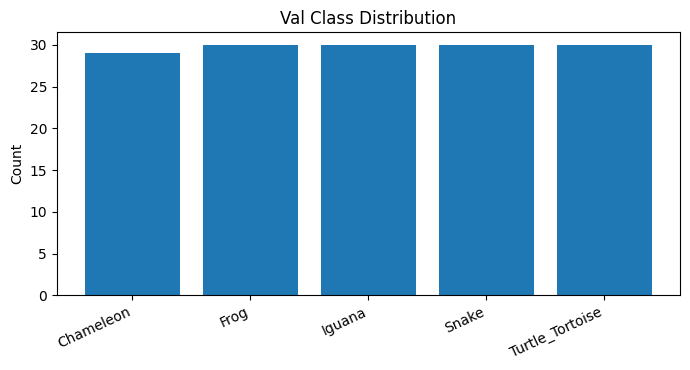

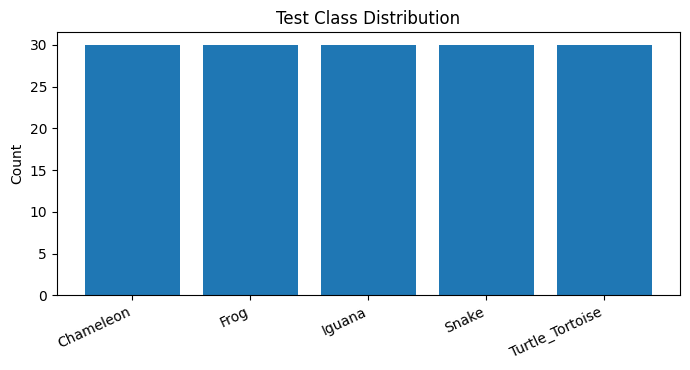

In [7]:
# Preview
def show_batch(dl, n=9):
    x, y = next(iter(dl))
    x, y = x[:n], y[:n]
    rows = int(np.sqrt(n)); cols = int(np.ceil(n/rows))
    plt.figure(figsize=(8,8))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x[i].permute(1,2,0).numpy())
        plt.axis('off'); plt.title(class_names[y[i].item()], fontsize=9)
    plt.tight_layout(); plt.show()

show_batch(train_loader, n=9)

# Distribusi kelas
def count_per_class(ds):
    return Counter([y for _, y in ds.samples])

def plot_dist(counter, title):
    xs = list(range(num_classes))
    ys = [counter.get(i, 0) for i in xs]
    plt.figure(figsize=(7,3.8))
    plt.bar(xs, ys)
    plt.xticks(xs, class_names, rotation=25, ha='right')
    plt.ylabel("Count"); plt.title(title)
    plt.tight_layout(); plt.show()

plot_dist(count_per_class(train_ds), "Train Class Distribution")
plot_dist(count_per_class(val_ds),   "Val Class Distribution")
plot_dist(count_per_class(test_ds),  "Test Class Distribution")


In [8]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience; self.min_delta = min_delta
        self.best = None; self.counter = 0; self.stop = False
    def step(self, metric):
        if self.best is None or metric < self.best - self.min_delta:
            self.best = metric; self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

def create_model(name, num_classes):
    model = timm.create_model(
        name, pretrained=True, num_classes=num_classes
    ).to(device)

    # freeze semua MLP
    freeze_mlp(model)

    # pakai channels_last (sedikit lebih cepat)
    model = model.to(memory_format=torch.channels_last)

    # compile (opsional, kalau PyTorch 2+)
    try:
        model = torch.compile(model)
    except:
        pass

    return model

def freeze_mlp(model):
    """
    Membekukan semua layer MLP/feed-forward pada transformer.
    Berlaku untuk ViT, DeiT, Swin, dan keluarga Swin lainnya.
    """
    for name, module in model.named_modules():
        if "mlp" in name.lower() or "ffn" in name.lower() or "ff" in name.lower():
            for param in module.parameters():
                param.requires_grad = False

    print("MLP layers frozen.")

scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

def run_epoch(model, loader, criterion, optimizer=None):
    train_mode = optimizer is not None
    model.train(train_mode)

    total, correct, loss_sum = 0, 0, 0.0
    all_preds, all_targets = [], []

    for x, y in tqdm(loader, leave=False):
        x = x.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        y = y.to(device, non_blocking=True)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x)
            loss = criterion(logits, y)

        if train_mode:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        loss_sum += loss.item() * y.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(y.detach().cpu().numpy())

    avg_loss = loss_sum / total
    acc = correct / total
    return avg_loss, acc, np.concatenate(all_preds), np.concatenate(all_targets)

def train_and_eval(model_name):
    model = create_model(model_name, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=max(EPOCHS - WARMUP_EPOCHS, 1)
    )

    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    early = EarlyStopper(patience=PATIENCE, min_delta=1e-4)
    best_state, best_val = None, 1e9

    for ep in range(1, EPOCHS+1):
        tr_loss, tr_acc, _, _ = run_epoch(model, train_loader, criterion, optimizer)
        if ep > WARMUP_EPOCHS:
            scheduler.step()
        va_loss, va_acc, va_preds, va_trg = run_epoch(model, val_loader, criterion, optimizer=None)

        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
        print(f"[{model_name}] Epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")

        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if early.step(va_loss) is None and early.stop:
            print("Early stopping.")
            break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    test_loss, test_acc, test_preds, test_trg = run_epoch(model, test_loader, criterion, optimizer=None)

    return {
        "name": model_name,
        "model": model,
        "history": history,
        "val_best_loss": best_val,
        "test_loss": test_loss,
        "test_acc":  test_acc,
        "test_preds": test_preds,
        "test_trg":   test_trg,
        "classes": class_names,
    }


/tmp/ipython-input-2188451926.py:44: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [9]:
# ======================
# Hyperparameters & Model Names
# ======================
IMG_SIZE = 224
BATCH_SIZE = 32

EPOCHS = 15
WARMUP_EPOCHS = 1
LR = 1e-4
WEIGHT_DECAY = 5e-2
PATIENCE = 4

MODEL_NAMES = [
    "swin_tiny_patch4_window7_224",
    "deit_tiny_patch16_224",
]

print("Hyperparams ready.")
print("Models:", MODEL_NAMES)


Hyperparams ready.
Models: ['swin_tiny_patch4_window7_224', 'deit_tiny_patch16_224']


In [10]:
def describe_model(model_name):
    import timm, torch

    model = timm.create_model(model_name, pretrained=False)

    # hitung parameter
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\n==============================")
    print(f"Model: {model_name}")
    print("==============================")
    print(f"Total Parameters    : {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")

    print("\n=== Layers ===")
    print(model)

# Print info semua model
for m in MODEL_NAMES:
    describe_model(m)

def count_trainable(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_total(model):
    return sum(p.numel() for p in model.parameters())

model_test = create_model("deit_small_patch16_224", num_classes)
print("Total parameters    :", count_total(model_test))
print("Trainable parameters:", count_trainable(model_test))



Model: swin_tiny_patch4_window7_224
Total Parameters    : 28,288,354
Trainable Parameters: 28,288,354

=== Layers ===
SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

MLP layers frozen.
Total parameters    : 21667589
Trainable parameters: 7488773


In [11]:
results = []
for name in MODEL_NAMES:
    out = train_and_eval(name)
    results.append(out)

print("\n=== Ringkasan singkat ===")
for r in results:
    print(f"{r['name']}: test_acc={r['test_acc']:.4f}, test_loss={r['test_loss']:.4f}, val_best_loss={r['val_best_loss']:.4f}")


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

MLP layers frozen.


  0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipython-input-2188451926.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
W1121 12:13:55.729000 420 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode
  5%|▍         | 1/22 [02:33<53:53, 153.97s/it]/tmp/ipython-input-2188451926.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-2188451926.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
 20%|██        | 1/5 [02:19<09:17, 139.46s/it]/tmp/ipython-input-2188451926.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is depreca

[swin_tiny_patch4_window7_224] Epoch 01 | train 0.9702/0.726 | val 0.2392/0.933


[swin_tiny_patch4_window7_224] Epoch 02 | train 0.1413/0.951 | val 0.2111/0.940


[swin_tiny_patch4_window7_224] Epoch 03 | train 0.0684/0.984 | val 0.2824/0.913


[swin_tiny_patch4_window7_224] Epoch 04 | train 0.0360/0.991 | val 0.2170/0.926


[swin_tiny_patch4_window7_224] Epoch 05 | train 0.0171/1.000 | val 0.2671/0.933


[swin_tiny_patch4_window7_224] Epoch 06 | train 0.0146/1.000 | val 0.2401/0.946
Early stopping.


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

MLP layers frozen.


  5%|▍         | 1/22 [00:27<09:44, 27.85s/it]/tmp/ipython-input-2188451926.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-2188451926.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
 20%|██        | 1/5 [00:12<00:49, 12.46s/it]/tmp/ipython-input-2188451926.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[deit_tiny_patch16_224] Epoch 01 | train 1.2754/0.524 | val 0.7650/0.792


[deit_tiny_patch16_224] Epoch 02 | train 0.4021/0.919 | val 0.4578/0.852


[deit_tiny_patch16_224] Epoch 03 | train 0.1498/0.963 | val 0.4284/0.859


[deit_tiny_patch16_224] Epoch 04 | train 0.0723/0.991 | val 0.4247/0.866


[deit_tiny_patch16_224] Epoch 05 | train 0.0407/0.993 | val 0.4314/0.872


[deit_tiny_patch16_224] Epoch 06 | train 0.0386/0.993 | val 0.4721/0.839


[deit_tiny_patch16_224] Epoch 07 | train 0.0380/0.993 | val 0.4318/0.866


[deit_tiny_patch16_224] Epoch 08 | train 0.0150/1.000 | val 0.3791/0.886


[deit_tiny_patch16_224] Epoch 09 | train 0.0095/1.000 | val 0.3977/0.886


[deit_tiny_patch16_224] Epoch 10 | train 0.0088/1.000 | val 0.3852/0.879


[deit_tiny_patch16_224] Epoch 11 | train 0.0074/1.000 | val 0.3917/0.886


[deit_tiny_patch16_224] Epoch 12 | train 0.0071/1.000 | val 0.3962/0.879
Early stopping.



=== Ringkasan singkat ===
swin_tiny_patch4_window7_224: test_acc=0.9333, test_loss=0.1989, val_best_loss=0.2111
deit_tiny_patch16_224: test_acc=0.8933, test_loss=0.3634, val_best_loss=0.3791


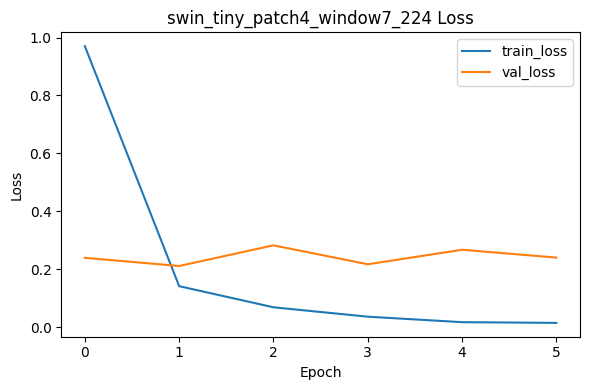

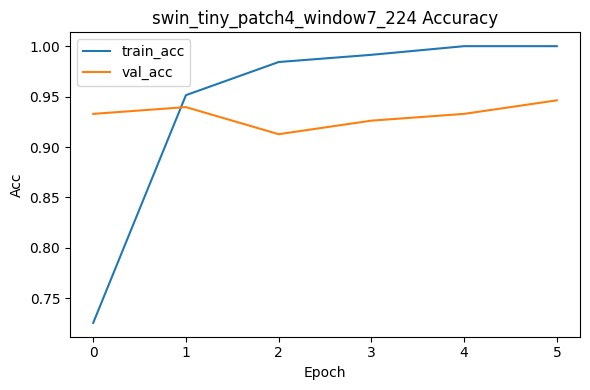

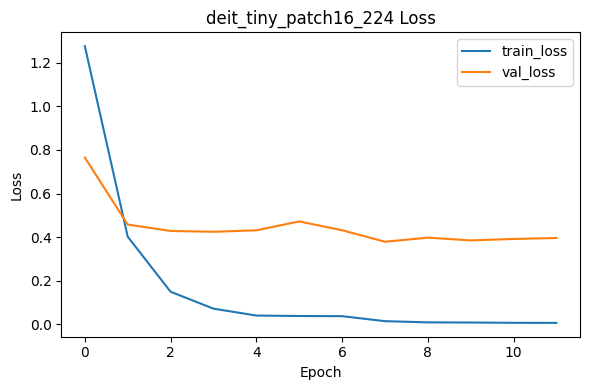

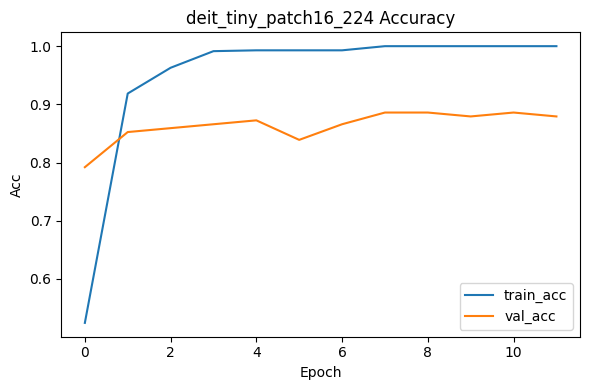

In [12]:
def plot_curves(history, title_prefix=""):
    plt.figure(figsize=(6,4))
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.title(f"{title_prefix} Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history["train_acc"], label="train_acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.title(f"{title_prefix} Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc")
    plt.legend(); plt.tight_layout(); plt.show()

for r in results:
    plot_curves(r["history"], title_prefix=r["name"])


Best model: swin_tiny_patch4_window7_224 Test Acc: 0.9333333333333333
Classification report:
                 precision    recall  f1-score   support

      Chameleon     1.0000    0.7667    0.8679        30
           Frog     1.0000    1.0000    1.0000        30
         Iguana     0.7632    0.9667    0.8529        30
          Snake     1.0000    1.0000    1.0000        30
Turtle_Tortoise     0.9655    0.9333    0.9492        30

       accuracy                         0.9333       150
      macro avg     0.9457    0.9333    0.9340       150
   weighted avg     0.9457    0.9333    0.9340       150



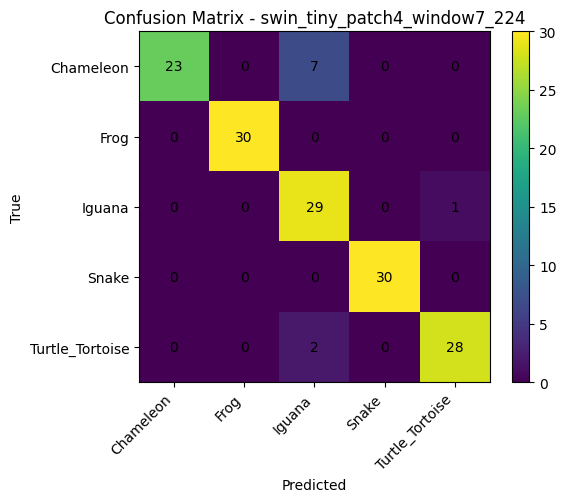

In [13]:
best = max(results, key=lambda x: x["test_acc"])
print("Best model:", best["name"], "Test Acc:", best["test_acc"])

cm = confusion_matrix(best["test_trg"], best["test_preds"], labels=list(range(num_classes)))
print("Classification report:")
print(classification_report(best["test_trg"], best["test_preds"], target_names=class_names, digits=4))

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix - {best['name']}")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
plt.ylabel('True'); plt.xlabel('Predicted')
plt.tight_layout(); plt.show()


worst model: deit_tiny_patch16_224 Test Acc: 0.8933333333333333
Classification report:
                 precision    recall  f1-score   support

      Chameleon     0.8000    0.8000    0.8000        30
           Frog     0.9655    0.9333    0.9492        30
         Iguana     0.8276    0.8000    0.8136        30
          Snake     1.0000    1.0000    1.0000        30
Turtle_Tortoise     0.8750    0.9333    0.9032        30

       accuracy                         0.8933       150
      macro avg     0.8936    0.8933    0.8932       150
   weighted avg     0.8936    0.8933    0.8932       150



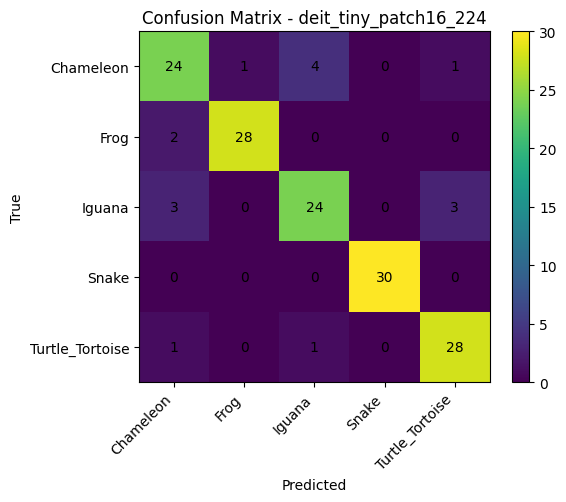

In [14]:
worst = min(results, key=lambda x: x["test_acc"])
print("worst model:", worst["name"], "Test Acc:", worst["test_acc"])

cm = confusion_matrix(worst["test_trg"], worst["test_preds"], labels=list(range(num_classes)))
print("Classification report:")
print(classification_report(worst["test_trg"], worst["test_preds"], target_names=class_names, digits=4))

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix - {worst['name']}")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
plt.ylabel('True'); plt.xlabel('Predicted')
plt.tight_layout(); plt.show()


In [15]:
def benchmark_inference(model, loader, n_runs=20):
    model.eval()
    x,_ = next(iter(loader))
    x = x.to(device)
    # warmup
    with torch.inference_mode():
        _ = model(x)
    times = []
    for _ in range(n_runs):
        start = time.time()
        with torch.inference_mode():
            _ = model(x)
        times.append(time.time()-start)
    batch_time = float(np.mean(times))
    per_image_ms = (batch_time / x.size(0)) * 1000
    throughput = x.size(0)/batch_time
    return batch_time, per_image_ms, throughput

bench = {}
for r in results:
    bt, ms, th = benchmark_inference(r["model"], test_loader)
    bench[r["name"]] = {"batch_s": bt, "per_image_ms": ms, "throughput": th}
bench


{'swin_tiny_patch4_window7_224': {'batch_s': 0.07978252172470093,
  'per_image_ms': 2.493203803896904,
  'throughput': 401.0903554843729},
 'deit_tiny_patch16_224': {'batch_s': 0.01639295816421509,
  'per_image_ms': 0.5122799426317215,
  'throughput': 1952.0576871753515}}

In [16]:
import pandas as pd
rows = []
for r in results:
    rows.append({
        "model": r["name"],
        "test_acc": r["test_acc"],
        "test_loss": r["test_loss"],
        "val_best_loss": r["val_best_loss"],
        "batch_s": bench[r["name"]]["batch_s"],
        "per_image_ms": bench[r["name"]]["per_image_ms"],
        "throughput_img_s": bench[r["name"]]["throughput"],
    })
df = pd.DataFrame(rows).sort_values("test_acc", ascending=False).reset_index(drop=True)
display(df)

best = max(results, key=lambda x: x["test_acc"])
save_path = f"best_{best['name']}.pt"
torch.save({"state_dict": best["model"].state_dict(),
            "classes": class_names,
            "img_size": IMG_SIZE,
            "model_name": best["name"]}, save_path)

df.to_csv("resultsfreeze_summary.csv", index=False)
print("Saved model to:", save_path)
print("Saved results to: resultsfreeze_summary.csv")

# Simpan model dengan performa TERBURUK
worst = min(results, key=lambda x: x["test_acc"])
save_path_worst = f"worst_{worst['name']}.pt"

torch.save({
    "state_dict": worst["model"].state_dict(),
    "classes": class_names,
    "img_size": IMG_SIZE,
    "model_name": worst["name"]
}, save_path_worst)

print("Saved WORST model to:", save_path_worst)


,model,test_acc,test_loss,val_best_loss,batch_s,per_image_ms,throughput_img_s
0,swin_tiny_patch4_window7_224,0.933333,0.198941,0.211125,0.079783,2.493204,401.090355
1,deit_tiny_patch16_224,0.893333,0.363404,0.379091,0.016393,0.512280,1952.057687


Saved model to: best_swin_tiny_patch4_window7_224.pt
Saved results to: resultsfreeze_summary.csv
Saved WORST model to: worst_deit_tiny_patch16_224.pt


In [18]:
from google.colab import drive
drive.mount('/content/drive')

SAVE_DIR = "/content/drive/MyDrive/animal_class/freeze"
os.makedirs(SAVE_DIR, exist_ok=True)
!cp -v *.pt "$SAVE_DIR" || true
!cp -v resultsfreeze_summary.csv "$SAVE_DIR" || true
print("Artifacts copied to:", SAVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'best_swin_tiny_patch4_window7_224.pt' -> '/content/drive/MyDrive/animal_class/freeze/best_swin_tiny_patch4_window7_224.pt'
'worst_deit_tiny_patch16_224.pt' -> '/content/drive/MyDrive/animal_class/freeze/worst_deit_tiny_patch16_224.pt'
'resultsfreeze_summary.csv' -> '/content/drive/MyDrive/animal_class/freeze/resultsfreeze_summary.csv'
Artifacts copied to: /content/drive/MyDrive/animal_class/freeze
